=== STEP 1: Problem Setup ===
Training inputs X:
[[0.]
 [1.]
 [2.]]
Training labels y: [0. 1. 0.]
Number of points N: 3
Kernel hyperparameters: kappa=1.0, lengthscale=1.0

=== STEP 2: Kernel Matrix K ===
Kernel matrix K:
[[1.         0.60653067 0.13533528]
 [0.60653067 1.         0.60653067]
 [0.13533528 0.60653067 1.        ]]

=== STEP 3: Cholesky Decomposition ===
Cholesky factor L:
[[1.0000005  0.         0.        ]
 [0.60653037 0.79506093 0.        ]
 [0.13533522 0.6596297  0.73930645]]
Verification K ≈ L @ L.T:
[[1.000001   0.60653067 0.13533528]
 [0.60653067 1.000001   0.6065307 ]
 [0.13533528 0.6065307  1.000001  ]]
log|K| = -1.0628

=== STEP 4: MAP Estimation ===
Starting optimization...
MAP estimate f_MAP: [-0.20178856 -0.03642649 -0.20178858]
log p(y, f_MAP): -4.2131

=== STEP 5: Hessian and Posterior Covariance ===
Λ diagonal entries: [0.24747226 0.24991708 0.24747226]
Λ matrix:
[[0.24747226 0.         0.        ]
 [0.         0.24991708 0.        ]
 [0.         0.        

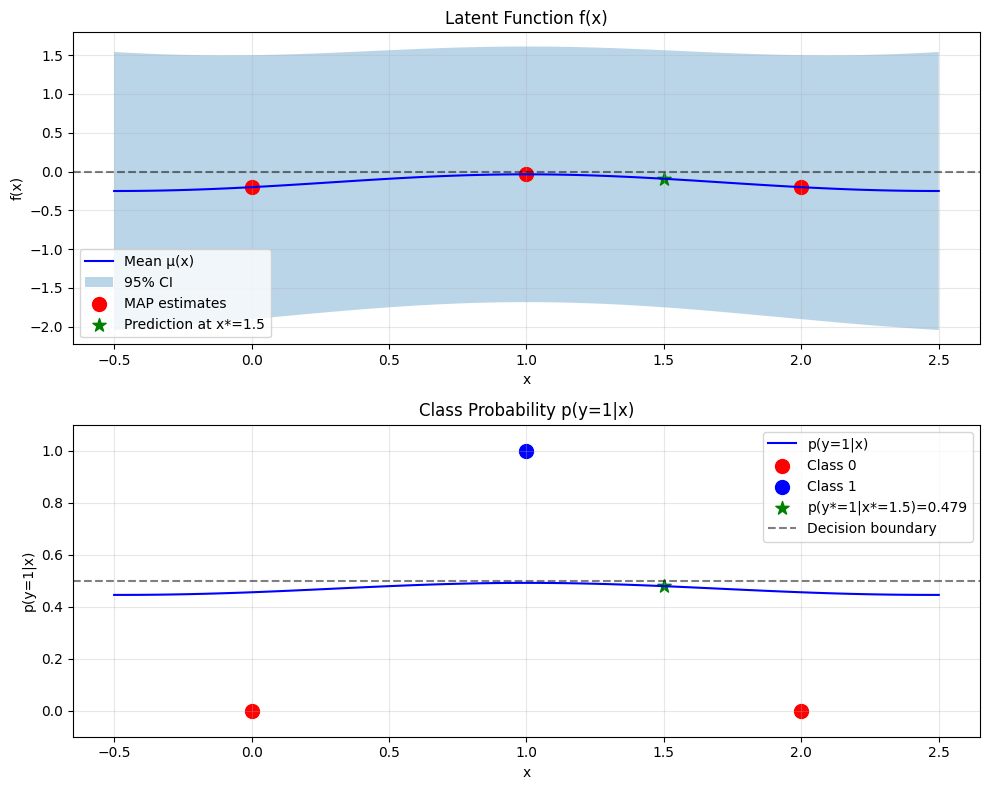

In [3]:
import jax.numpy as jnp
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Sigmoid function
def sigmoid(f):
    return 1 / (1 + jnp.exp(-f))

# Squared exponential kernel
def squared_exponential(x1, x2, kappa=1.0, lengthscale=1.0):
    dist_sq = jnp.sum((x1 - x2)**2)
    return kappa * jnp.exp(-dist_sq / (2 * lengthscale**2))

# Probit function (CDF of standard normal)
def probit(x):
    return norm.cdf(x)

# =============================================================================
# STEP 1: Problem Setup
# =============================================================================
print("=== STEP 1: Problem Setup ===")
X = jnp.array([[0.], [1.], [2.]])  # Training inputs
y = jnp.array([0., 1., 0.])       # Training labels
N = len(X)
print(f"Training inputs X:\n{X}")
print(f"Training labels y: {y}")
print(f"Number of points N: {N}")

# Kernel hyperparameters
kappa = 1.0
lengthscale = 1.0
print(f"Kernel hyperparameters: kappa={kappa}, lengthscale={lengthscale}")

# =============================================================================
# STEP 2: Prior Calculations - Kernel Matrix K
# =============================================================================
print("\n=== STEP 2: Kernel Matrix K ===")
K = jnp.zeros((N, N))
for i in range(N):
    for j in range(N):
        K = K.at[i, j].set(squared_exponential(X[i], X[j], kappa, lengthscale))
        
print(f"Kernel matrix K:\n{K}")

# =============================================================================
# STEP 3: Cholesky Decomposition
# =============================================================================
print("\n=== STEP 3: Cholesky Decomposition ===")
L = jnp.linalg.cholesky(K + 1e-6 * jnp.eye(N))  # Adding small jitter for stability
print(f"Cholesky factor L:\n{L}")

# Verify: K ≈ L @ L.T
print(f"Verification K ≈ L @ L.T:\n{L @ L.T}")

# Log determinant
log_det_K = 2 * jnp.sum(jnp.log(jnp.diag(L)))
print(f"log|K| = {log_det_K:.4f}")

# =============================================================================
# STEP 4: MAP Estimation
# =============================================================================
print("\n=== STEP 4: MAP Estimation ===")

def log_joint(f):
    """Log joint distribution log p(y,f) = log p(y|f) + log p(f)"""
    # Log prior: -N/2 log(2π) - 1/2 log|K| - 1/2 f^T K^{-1} f
    const = -N/2 * jnp.log(2 * jnp.pi)
    K_inv_f = jnp.linalg.solve(K, f)
    quad_term = 0.5 * jnp.dot(f, K_inv_f)
    log_prior = const - 0.5 * log_det_K - quad_term
    
    # Log likelihood: Σ[y_i log σ(f_i) + (1-y_i) log(1-σ(f_i))]
    log_lik = jnp.sum(y * jnp.log(sigmoid(f) + 1e-10) + 
                      (1 - y) * jnp.log(1 - sigmoid(f) + 1e-10))
    
    return log_prior + log_lik

def gradient_log_joint(f):
    """Gradient of log joint w.r.t. f"""
    # Gradient from likelihood: y - σ(f)
    grad_lik = y - sigmoid(f)
    
    # Gradient from prior: -K^{-1}f
    grad_prior = -jnp.linalg.solve(K, f)
    
    return grad_lik + grad_prior

# Optimize to find MAP
print("Starting optimization...")
result = minimize(lambda f: -log_joint(f),
                  jac=lambda f: -gradient_log_joint(f),
                  x0=jnp.zeros(N),
                  method='BFGS')

f_MAP = result.x
print(f"MAP estimate f_MAP: {f_MAP}")
print(f"log p(y, f_MAP): {log_joint(f_MAP):.4f}")

# =============================================================================
# STEP 5: Hessian and Posterior Covariance
# =============================================================================
print("\n=== STEP 5: Hessian and Posterior Covariance ===")

# Compute Λ (negative Hessian of log likelihood)
Lambda_diag = sigmoid(f_MAP) * (1 - sigmoid(f_MAP))
Lambda = jnp.diag(Lambda_diag)
print(f"Λ diagonal entries: {Lambda_diag}")
print(f"Λ matrix:\n{Lambda}")

# Compute posterior covariance S using Woodbury identity
# S = K - K Λ^{1/2} (I + Λ^{1/2} K Λ^{1/2})^{-1} Λ^{1/2} K
print("\nComputing posterior covariance S via Woodbury...")

# Step 1: Compute Λ^{1/2}
Lambda_sqrt = jnp.diag(jnp.sqrt(Lambda_diag))
print(f"Λ^{1/2}:\n{Lambda_sqrt}")

# Step 2: Compute B = I + Λ^{1/2} K Λ^{1/2}
B = jnp.eye(N) + Lambda_sqrt @ K @ Lambda_sqrt
print(f"B = I + Λ^{1/2} K Λ^{1/2}:\n{B}")

# Step 3: Cholesky decomposition of B
L_B = jnp.linalg.cholesky(B + 1e-6 * jnp.eye(N))
print(f"Cholesky of B:\n{L_B}")

# Step 4: Solve for e
e = jnp.linalg.solve(L_B, Lambda_sqrt @ K)
print(f"e = L_B^{-1} Λ^{1/2} K shape: {e.shape}")

# Step 5: Compute S
S = K - e.T @ e
print(f"Posterior covariance S:\n{S}")

# =============================================================================
# STEP 6: Prediction at x* = 1.5
# =============================================================================
print("\n=== STEP 6: Prediction at x* = 1.5 ===")
x_star = jnp.array([[1.5]])

# Compute covariances
k_star = jnp.array([squared_exponential(x_star[0], X[i], kappa, lengthscale) 
                    for i in range(N)])
k_star_star = squared_exponential(x_star[0], x_star[0], kappa, lengthscale)

print(f"k* (covariance with training points): {k_star}")
print(f"k** (prior variance at x*): {k_star_star}")

# Compute K^{-1}
K_inv = jnp.linalg.inv(K + 1e-6 * jnp.eye(N))
print(f"K^{-1}:\n{K_inv}")

# Compute K^{-1}m
K_inv_m = K_inv @ f_MAP
print(f"K^{-1}m: {K_inv_m}")

# Predictive mean
mu_star = k_star @ K_inv_m
print(f"Predictive mean μ*: {mu_star:.4f}")

# Predictive variance
K_inv_k_star = K_inv @ k_star
print(f"K^{-1}k*: {K_inv_k_star}")

# K - S 
K_minus_S = K - S
print(f"K - S:\n{K_minus_S}")

# Variance calculation
var_term = k_star @ K_inv @ K_minus_S @ K_inv_k_star
sigma_star_sq = k_star_star - var_term
print(f"Predictive variance σ*²: {sigma_star_sq:.4f}")
print(f"Predictive std σ*: {jnp.sqrt(sigma_star_sq):.4f}")

# =============================================================================
# STEP 7: Class Probability Prediction
# =============================================================================
print("\n=== STEP 7: Class Probability Prediction ===")

# Using probit approximation
denominator = jnp.sqrt(8/jnp.pi + sigma_star_sq)
print(f"Denominator √(8/π + σ*²): {denominator:.4f}")

p_y_star_1 = probit(mu_star / denominator)
print(f"p(y*=1 | x*=1.5): {p_y_star_1:.4f}")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n=== SUMMARY ===")
print(f"Training data: X = {X.ravel()}, y = {y}")
print(f"MAP estimate: f_MAP = {f_MAP}")
print(f"Test point: x* = {x_star[0, 0]}")
print(f"Predictive mean: μ* = {mu_star:.4f}")
print(f"Predictive std: σ* = {jnp.sqrt(sigma_star_sq):.4f}")
print(f"Class probability: p(y*=1) = {p_y_star_1:.4f}")

# =============================================================================
# Visualization
# =============================================================================
import matplotlib.pyplot as plt

# Create a grid of test points
x_test = jnp.linspace(-0.5, 2.5, 100).reshape(-1, 1)
mu_test = []
var_test = []
p_test = []

for x in x_test:
    # Compute covariances
    k_x = jnp.array([squared_exponential(x[0], X[i], kappa, lengthscale) 
                     for i in range(N)])
    k_xx = squared_exponential(x[0], x[0], kappa, lengthscale)
    
    # Predictive mean and variance
    mu_x = k_x @ K_inv_m
    var_x = k_xx - k_x @ K_inv @ K_minus_S @ K_inv @ k_x
    
    # Class probability
    p_x = probit(mu_x / jnp.sqrt(8/jnp.pi + var_x))
    
    mu_test.append(mu_x)
    var_test.append(var_x)
    p_test.append(p_x)

mu_test = jnp.array(mu_test)
var_test = jnp.array(var_test)
p_test = jnp.array(p_test)
std_test = jnp.sqrt(var_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Latent function
ax1.plot(x_test, mu_test, 'b-', label='Mean μ(x)')
ax1.fill_between(x_test.ravel(), 
                 mu_test - 1.96*std_test, 
                 mu_test + 1.96*std_test,
                 alpha=0.3, label='95% CI')
ax1.scatter(X.ravel(), f_MAP, c='r', s=100, label='MAP estimates')
ax1.scatter([1.5], [mu_star], c='g', s=100, marker='*', label=f'Prediction at x*={x_star[0,0]}')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.set_title('Latent Function f(x)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Class probabilities
ax2.plot(x_test, p_test, 'b-', label='p(y=1|x)')
n0 = int((y == 0).sum())          # .item() also works
n1 = int((y == 1).sum())

ax2.scatter(X[y == 0], jnp.zeros(n0), c='r', s=100, marker='o', label='Class 0')
ax2.scatter(X[y == 1], jnp.ones (n1), c='b', s=100, marker='o', label='Class 1')
ax2.scatter([1.5], [p_y_star_1], c='g', s=100, marker='*', 
           label=f'p(y*=1|x*={x_star[0,0]})={p_y_star_1:.3f}')
ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision boundary')
ax2.set_xlabel('x')
ax2.set_ylabel('p(y=1|x)')
ax2.set_title('Class Probability p(y=1|x)')
ax2.set_ylim(-0.1, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()